
## Plotting Cap Volatility

In this section, we visualize the cap volatilities across different maturities or time intervals. Cap volatility represents the volatility of caplet rates for various maturities, which affects the pricing of cap/floor instruments. Visualizing these volatilities helps understand the term structure and how volatility varies across different maturities.
    

In [1]:
# Import necessary libraries for plotting
import QuantLib as ql

In [2]:
yts = ql.RelinkableYieldTermStructureHandle()

instruments = [
    ('depo', '6M', 0.025),
    ('swap', '1Y', 0.031),
    ('swap', '2Y', 0.032),
    ('swap', '3Y', 0.035)
]

helpers = ql.RateHelperVector()
index = ql.Euribor6M(yts)
for instrument, tenor, rate in instruments:
    if instrument == 'depo':
        helpers.append( ql.DepositRateHelper(rate, index) )
    if instrument == 'fra':
        monthsToStart = ql.Period(tenor).length()
        helpers.append( ql.FraRateHelper(rate, monthsToStart, index) )
    if instrument == 'swap':
        swapIndex = ql.EuriborSwapIsdaFixA(ql.Period(tenor))
        helpers.append( ql.SwapRateHelper(rate, swapIndex))
curve = ql.PiecewiseLogCubicDiscount(2, ql.TARGET(), helpers, ql.Actual365Fixed())

In [3]:
yts.linkTo(curve)
engine = ql.DiscountingSwapEngine(yts)

In [4]:
tenor = ql.Period('2y')
fixedRate = 0.05
forwardStart = ql.Period("2D")

swap = ql.MakeVanillaSwap(tenor, index, fixedRate, forwardStart, nominal=10e6, pricingEngine=engine)

In [5]:
fairRate = swap.fairRate()
npv = swap.NPV()

print(f"Fair swap rate: {fairRate:.3%}")
print(f"Swap NPV: {npv:,.3f}")

Fair swap rate: 3.204%
Swap NPV: -343,142.754


In [6]:
# Import necessary libraries for plotting
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format

cashflows = pd.DataFrame({
    'date': cf.date(),
    'amount': cf.amount()
    } for cf in swap.leg(1))
display(cashflows)

,date,amount
0,"May 2nd, 2025","126,902.06"
1,"November 3rd, 2025","183,556.11"
2,"May 4th, 2026","163,923.74"
3,"November 2nd, 2026","162,672.58"


In [7]:
cashflows = pd.DataFrame({
    'nominal': cf.nominal(),
    'accrualStartDate': cf.accrualStartDate().ISO(),
    'accrualEndDate': cf.accrualEndDate().ISO(),
    'rate': cf.rate(),
    'amount': cf.amount()
    } for cf in map(ql.as_coupon, swap.leg(1)))
display(cashflows)

,nominal,accrualStartDate,accrualEndDate,rate,amount
0,"10,000,000.00",2024-11-01,2025-05-02,0.03,"126,902.06"
1,"10,000,000.00",2025-05-02,2025-11-03,0.04,"183,556.11"
2,"10,000,000.00",2025-11-03,2026-05-04,0.03,"163,923.74"
3,"10,000,000.00",2026-05-04,2026-11-02,0.03,"162,672.58"


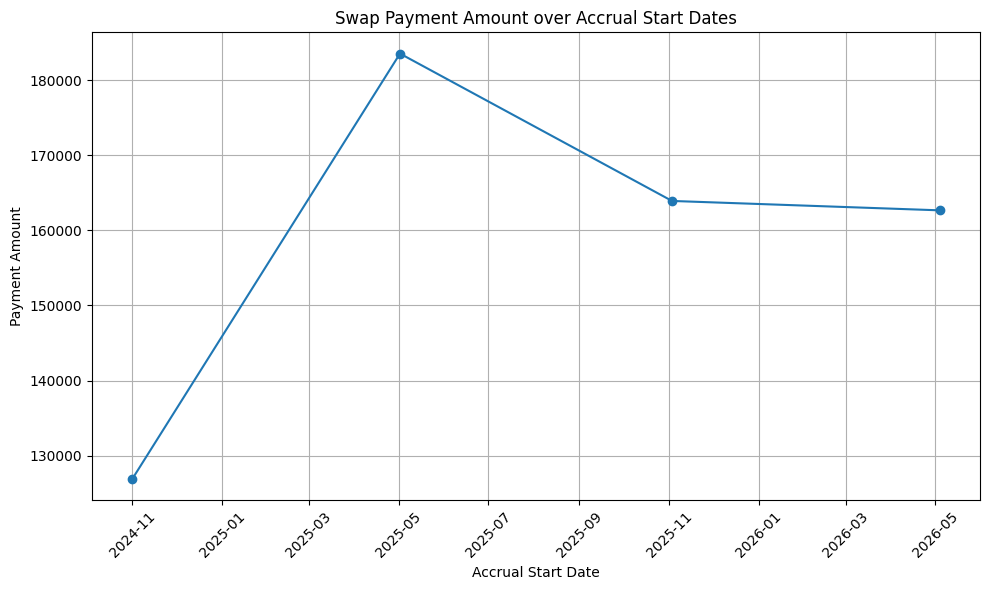

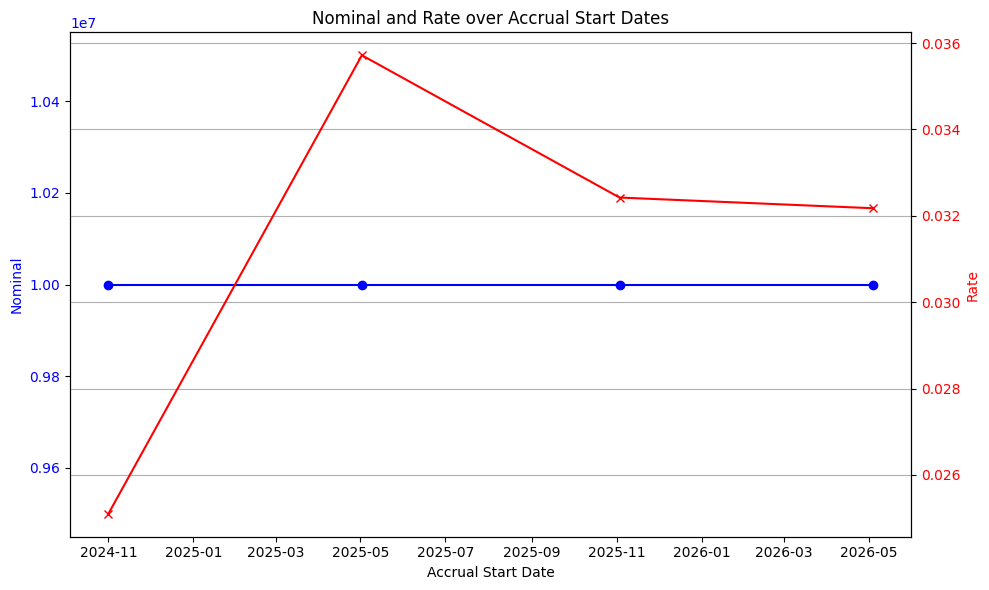

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Assuming `cashflows` is already defined in your notebook

# Convert accrualStartDate and accrualEndDate to datetime format for plotting
cashflows['accrualStartDate'] = pd.to_datetime(cashflows['accrualStartDate'])
cashflows['accrualEndDate'] = pd.to_datetime(cashflows['accrualEndDate'])

# Plotting amount over accrual start dates
plt.figure(figsize=(10, 6))
plt.plot(cashflows['accrualStartDate'], cashflows['amount'], marker='o', linestyle='-')
plt.xlabel('Accrual Start Date')
plt.ylabel('Payment Amount')
plt.title('Swap Payment Amount over Accrual Start Dates')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Plot nominal and rate if they vary over time
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot nominal
ax1.plot(cashflows['accrualStartDate'], cashflows['nominal'], color='b', marker='o', label='Nominal')
ax1.set_xlabel('Accrual Start Date')
ax1.set_ylabel('Nominal', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot rate on a secondary axis
ax2 = ax1.twinx()
ax2.plot(cashflows['accrualStartDate'], cashflows['rate'], color='r', marker='x', label='Rate')
ax2.set_ylabel('Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Nominal and Rate over Accrual Start Dates')
fig.tight_layout()
plt.grid(True)
plt.show()
